# **Assignment 3: DCGANs**
## **Name: Richa Gupta**
## **Batch: TY AIML B**
## **PRN: 22070126087**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.utils.data as data

In [2]:
# Defining hyperparameters
batch_size = 128
image_size = 64
nz = 100  # Size of latent vector
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
num_epochs = 10
lr = 0.0002
beta1 = 0.5  # Adam optimizer beta1

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Preprocessing the Data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalized to [-1, 1]
])

In [11]:
from google.colab import files
files.upload()  # Select kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"richag19","key":"5dd017b67f8e113186bd0ecf79483459"}'}

In [12]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:04<00:00, 24.3MB/s]
100% 1.33G/1.33G [01:04<00:00, 22.1MB/s]


In [16]:
!ls

celeba-dataset.zip  data  sample_data


In [17]:
!unzip -q celeba-dataset.zip -d ./data/
!ls ./data

celeba		  list_attr_celeba.csv	list_eval_partition.csv
img_align_celeba  list_bbox_celeba.csv	list_landmarks_align_celeba.csv


In [18]:
# Loading the CelebA dataset
dataset = datasets.ImageFolder(root='./data/img_align_celeba', transform=transform)
dataloader = data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [19]:
# Generator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [21]:
# Initializing models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [22]:
# Loss function and Optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
# Training Loop
real_label = 1.
fake_label = 0.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [24]:
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        # Train Discriminator with real images
        optimizerD.zero_grad()
        output = discriminator(real_images).view(-1)
        lossD_real = criterion(output, torch.full_like(output, real_label, device=device))
        lossD_real.backward()

        # Train Discriminator with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = generator(noise)
        output = discriminator(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, torch.full_like(output, fake_label, device=device))
        lossD_fake.backward()
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        output = discriminator(fake_images).view(-1)
        lossG = criterion(output, torch.full_like(output, real_label, device=device))
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {lossD_real.item() + lossD_fake.item()}, Loss G: {lossG.item()}")

Epoch [1/10], Loss D: 1.512306585907936, Loss G: 9.04265022277832
Epoch [2/10], Loss D: 0.5294704139232635, Loss G: 3.411592960357666
Epoch [3/10], Loss D: 1.5708946492522955, Loss G: 0.6572853922843933
Epoch [4/10], Loss D: 0.68797267973423, Loss G: 1.7030184268951416
Epoch [5/10], Loss D: 1.9060351438820362, Loss G: 4.46419095993042
Epoch [6/10], Loss D: 0.5953963398933411, Loss G: 2.633807897567749
Epoch [7/10], Loss D: 0.5532152652740479, Loss G: 1.7244584560394287
Epoch [8/10], Loss D: 0.6509490460157394, Loss G: 1.0786939859390259
Epoch [9/10], Loss D: 0.458031564950943, Loss G: 2.406034469604492
Epoch [10/10], Loss D: 0.8307589404284954, Loss G: 0.8139720559120178


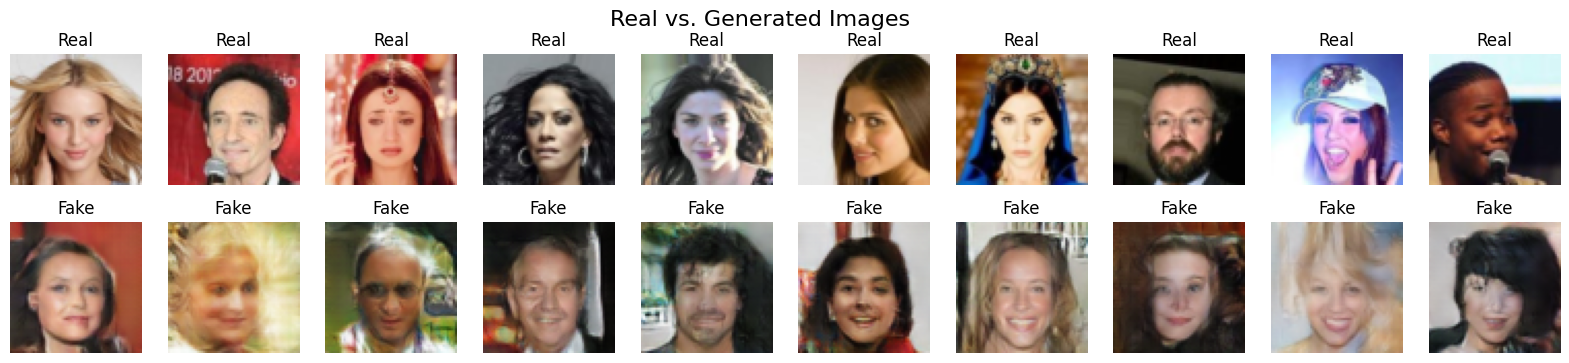

In [25]:
# Generate Sample Images
generator.eval()
with torch.no_grad():
    fake_images = generator(fixed_noise).cpu()

# Get real images from the dataset
real_images, _ = next(iter(dataloader))  # Fetch a batch of real images
real_images = real_images[:10].cpu()  # Select the first 10 real images

# Create a figure for visualization
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot real images (top row)
for i in range(10):
    axes[0, i].imshow(np.transpose(real_images[i] * 0.5 + 0.5, (1, 2, 0)))  # Denormalize
    axes[0, i].axis("off")
    axes[0, i].set_title("Real")

# Plot generated images (bottom row)
for i in range(10):
    axes[1, i].imshow(np.transpose(fake_images[i] * 0.5 + 0.5, (1, 2, 0)))  # Denormalize
    axes[1, i].axis("off")
    axes[1, i].set_title("Fake")

plt.suptitle("Real vs. Generated Images", fontsize=16)
plt.show()